# Benchmark on OGB, https://ogb.stanford.edu/docs/home/

In [1]:
import random
import argparse
import configparser
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_sparse
from torch import Tensor
from torch.nn import Linear
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.optim as optim

from torch_geometric.utils import negative_sampling, to_networkx
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

from ogb.linkproppred import PygLinkPropPredDataset, Evaluator


import networkx as nx
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import scipy
import math

import matplotlib.pyplot as plt

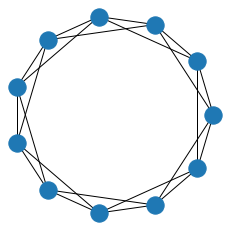

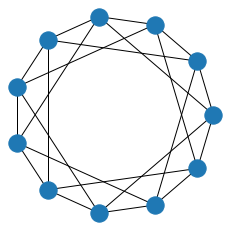

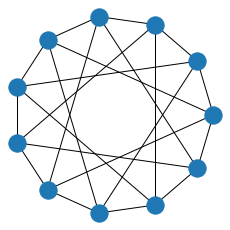

In [2]:
# NOTE: plot graphs:

# circulant graph:

cg = nx.circulant_graph(11, [1, 2])

plt.figure(figsize=(3,3))
nx.draw_circular(cg)


cg = nx.circulant_graph(11, [1, 3])

plt.figure(figsize=(3,3))
nx.draw_circular(cg)

cg = nx.circulant_graph(11, [1, 4])

plt.figure(figsize=(3,3))
nx.draw_circular(cg)
# circulant ladder graph:



In [3]:
def get_spd_matrix(G, S, max_spd=5):
    spd_matrix = np.zeros((G.number_of_nodes(), len(S)), dtype=np.float32)
    for i, node_S in enumerate(S):
        for node, length in nx.shortest_path_length(G, source=node_S).items():
            spd_matrix[node, i] = min(length, max_spd)
    return spd_matrix


class Logger(object):
    def __init__(self, runs, info=None):
        self.info = info
        self.results = [[] for _ in range(runs)]

    def add_result(self, run, result):
        assert len(result) == 2
        assert run >= 0 and run < len(self.results)
        self.results[run].append(result)

    def print_statistics(self, run=None):
        if run is not None:
            result = 100 * torch.tensor(self.results[run])
            argmax = result[:, 0].argmax().item()
            print(f'Run {run + 1:02d}:')
            print(f'Highest Valid: {result[:, 0].max():.2f}')
            print(f'   Final Test: {result[argmax, 1]:.2f}')
        else:
            result = 100 * torch.tensor(self.results)
            best_results = []
            for r in result:
                valid = r[:, 0].max().item()
                test = r[r[:, 0].argmax(), 1].item()
                best_results.append((valid, test))
            best_result = torch.tensor(best_results)
            print(f'All runs:')
            r = best_result[:, 0]
            print(f'Highest Valid: {r.mean():.4f} ± {r.std():.4f}')
            r = best_result[:, 1]
            print(f'   Final Test: {r.mean():.4f} ± {r.std():.4f}')


class SAGEConv(MessagePassing):
    r"""The GraphSAGE operator from the `"Inductive Representation Learning on
    Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W}_2 \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        normalize (bool, optional): If set to :obj:`True`, output features
            will be :math:`\ell_2`-normalized, *i.e.*,
            :math:`\frac{\mathbf{x}^{\prime}_i}
            {\| \mathbf{x}^{\prime}_i \|_2}`.
            (default: :obj:`False`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, normalize: bool = False,
                 root_weight: bool = True,
                 bias: bool = True, **kwargs):  # yapf: disable
        kwargs.setdefault('aggr', 'mean')
        super(SAGEConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.root_weight = root_weight

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        if self.root_weight:
            self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        if self.root_weight:
            self.lin_r.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # Node and edge feature dimensionalites need to match.
        if isinstance(edge_index, Tensor):
            assert edge_attr is not None
            assert x[0].size(-1) == edge_attr.size(-1)
        elif isinstance(edge_index, SparseTensor):
            assert x[0].size(-1) == edge_index.size(-1)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)
        out = self.lin_l(out)

        x_r = x[1]
        if self.root_weight and x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out


    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        return F.relu(x_j + edge_attr)


    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GraphSAGE,self).__init__()
        self.convs = torch.nn.ModuleList()
        
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t, edge_attr, emb_ea):
        edge_attr = torch.mm(edge_attr, emb_ea)
        for conv in self.convs[:-1]:
            x = conv(x, adj_t, edge_attr)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t, edge_attr)  # no nonlinearity
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)






# Graph Generation

https://networkx.org/documentation/latest/tutorial.html#graph-generators-and-graph-operations



# Generate ER-graph Dataset: 1. invariant to node; 2. variant to node.
# Generate SBM-graph Dataset: 1. invariant to node; 2. variant to node.



# synthetic dataset generation
---
- a) `permutation invariant`
- b) `permutation variant`
- c) `build pipeline to construct node feautures.`
- d) `build pipeline to construct graph feautures, e.g., laplacian matrix, wavelets, etc.`


In [4]:
# TODO, d), graph feature pipeline.


def add_graph_features(graph_features, cons_fea_func, c_dim=0):
    """input:
            by default, the graph feature at dim=0 of graph_features (numpy) is the original adj matrix.
            graph_features shape: (B, N, N, C), where C is the graph feature number.
            cons_fea_func is the function to construct new graph features with NxN and append to the C-th dimension.
            
            by default, c_dim is 0, use the first adjacency matrix to construct new features. 
       return:
            graph_features, shape will be (B, N, N, C+1). 
    """
    if graph_features.ndim == 3:
        graph_features = np.expand_dims(graph_features, axis=-1)
        
    new_graph_features = []
    for ori_feature in graph_features[..., c_dim]:
        new_graph_features.append(cons_fea_func(ori_feature))
    
    new_graph_features = np.expand_dims(np.stack(new_graph_features, axis=0), axis=-1)
    
    graph_features = np.concatenate([graph_features, new_graph_features], axis=-1)
    
    return graph_features


def composite_node_features(*node_features, padding=False, padding_len=128, pad_value=0):
    """ just concatenate the new_node_features with the cur_node_features (N, C1)
        output new node features: (N, C1+C2)
    """
    if isinstance(node_features[0], list):
        res = []
        for i in range(len(node_features[0])):
            fea = np.concatenate((node_features[0][i],node_features[1][i]), axis=-1)
            if padding:
                fea = np.pad(fea, ((0,0),(0, padding_len-fea.shape[-1])), mode='constant', constant_values=pad_value)
            res.append(fea)
        return res
    
    fea = np.concatenate(node_features, axis=-1)
    if padding:
        fea = np.pad(fea, ((0,padding_len-fea.shape[-1])), mode='constant', constant_values=pad_value)
        
    return fea
    
    

In [ ]:
a = np.array(1).astype(np.float32)
print(a)
b = np.stack([a,2*a])
print(b.shape)

In [5]:
from functools import reduce



def connect_graphs(g1, g2):
    n1 = list(g1.nodes)
    n2 = list(g2.nodes)
    e1 = random.choices(n1, k=1)[0]
    e2 = random.choices(n2, k=1)[0]
    g_cur = nx.compose(g1, g2)
    g_cur.add_edge(e1, e2)
    return g_cur

def random_connect_graph(graph_list:list):
    # NOTE: relabeling the nodes.
    
    new_graphs = []
    np.random.shuffle(graph_list)
    node_idx = 0
    for g in graph_list:
        len_nodes = len(list(g.nodes))
        mapping = {}
        for i in range(len_nodes):
            mapping[i] = i+node_idx
        new_g = nx.relabel_nodes(g, mapping)
        new_graphs.append(new_g)
        node_idx += len_nodes
        
    g_all = reduce(connect_graphs, new_graphs)
    
    return g_all


def generate_circulant_graph_samples(each_class_num:int, N:int, S:list):
    samples = []
    for s in S:
        g = nx.circulant_graph(N, [1, s])
        # pers = set()
        # if each_class_num < math.factorial(N):
        #     uniq_per = set()
        #     while len(uniq_per) < each_class_num:
        #         per = np.random.permutation(list(np.arange(0, 8)))
        #         pers.add()
        # else:
        pers = [np.random.permutation(list(np.arange(0, N))) for _ in range(each_class_num)]

        A_g = nx.to_scipy_sparse_matrix(g).todense()
        # Permutate:
        for per in pers:
            A_per = A_g[per, :]
            A_per = A_per[:, per]
            # NOTE: set cycle length or skip length as label.
            samples.append((nx.from_numpy_array(A_per), np.array(s).astype(np.float32)))
    
    return generate_training_graphs(samples)


def generate_training_graphs(graphs_cc):

    np.random.shuffle(graphs_cc)
    
    test_sample_size = int(len(graphs_cc)/3)
    train_adjs, train_y, test_adjs, test_y = [],[],[],[]
    
    for g in graphs_cc[:-test_sample_size]:
        # TODO: generate some deviation:
        if isinstance(g, tuple):
            adj, y = g
            train_adjs.append(adj)
            train_y.append(y)
        else:
            train_adjs.append(g)
            train_y.append(nx.average_clustering(g))
        
    for g in graphs_cc[-test_sample_size:]:
        if isinstance(g, tuple):
            adj, y = g
            test_adjs.append(adj)
            test_y.append(y)
        else:
            test_adjs.append(g)
            test_y.append(nx.average_clustering(g))
            
    train_adjs = [nx.to_scipy_sparse_matrix(g) for g in train_adjs]
    test_adjs = [nx.to_scipy_sparse_matrix(g) for g in test_adjs]


    train_y = np.stack(train_y, axis=0)
    test_y = np.stack(test_y, axis=0)
    
    return (train_adjs, train_y, test_adjs, test_y)
    

def generate_cc_no_degree_corr_samples(cc_range_num=20, rand_con=True):
    
    def random_add_edges(graph, E=3):
        nodes = list(graph.nodes)
        for i in range(E):
            e = random.sample(nodes, k=2)
            graph.add_edge(*e)
        return graph
        
    cc_range_num = cc_range_num
    graphs_cc = []
    for k in range(1, cc_range_num):
        m = cc_range_num - k
        G_tri = [nx.complete_graph(3) for _ in range(k)]
        G_sqr = [nx.cycle_graph(4) for _ in range(m)]
        cur_graphs = [random_connect_graph(utils.flatten_list([G_tri, G_sqr])) for _ in range(5)]
        # repeat for 5 times:
        for _ in range(5):
            [graphs_cc.append(random_add_edges(g, E=3)) for g in cur_graphs]        

    return generate_training_graphs(graphs_cc)
    
def get_value(xargs, key, default=None):
    """return (N, 1) all one node feature
    """
    return xargs[key] if key in xargs else default

# node or edge feature generation:

def xargs(f):
    def wrap(**xargs):
        return f(**xargs)
    return wrap

@xargs
def node_tri_cycles_feature(adj, k=2):
    """ A^k as node features. so the dim of feature equals to the number of nodes.
    """

    if not isinstance(adj, np.ndarray):
        adj = adj.todense()
    adj = np.multiply(adj, np.matmul(adj, adj))
    adj = np.sum(adj, axis=1).reshape(-1, 1)
    return adj.astype(np.float32)

@xargs
def node_k_adj_feature(adj, k=2):
        
    """ A^k as node features. so the dim of feature equals to the number of nodes.
    """
    if not isinstance(adj, np.ndarray):
        adj = adj.todense()
    ori_adj = adj
    for _ in range(k-1):
        adj = np.matmul(adj, ori_adj)
    return adj.astype(np.float32)

@xargs
def node_degree_feature(adj):
    """ node (weighted, if its weighted adjacency matrix) degree as the node feature.
    """
    
    if not isinstance(adj, np.ndarray):
        adj = adj.todense()
    degrees = np.sum(adj, axis=1).reshape(adj.shape[0], 1)
    return degrees.astype(np.float32)


@xargs
def node_random_id_feature(adj, ratio=1.0):
        
    if not isinstance(adj, np.ndarray):
        adj = adj.todense()

    N = adj.shape[0]
    id_features = np.random.randint(1, int(N*ratio), size=N).reshape(N, 1).astype(np.float32)
    return id_features

@xargs
def node_allone_feature(adj):
    """return (N, 1) all one node feature
    """
    if not isinstance(adj, np.ndarray):
        adj = adj.todense()
        
    N = adj.shape[0]
    return np.ones(N).reshape(N, 1).astype(np.float32)


@xargs
def node_gaussian_feature(adj, mean_v=0.1, std_v=1.0):
    if not isinstance(adj, np.ndarray):
        adj = adj.todense()
        
    N = adj.shape[0]
    
    return np.random.normal(loc=mean_v, scale=std_v, size=(N, 1)).astype(np.float32)



@xargs
def node_index_feature(adj):
    """return (N, 1) node feature, feature equals to the index+1
    """
    N = adj.shape[0]
    return np.arange(1, N+1).reshape(N, 1).astype(np.float32)

@xargs
def node_deviated_feature(adj):
    N = adj.shape[0]
    block_N = int(N/2)
    fea1 = np.arange(1, block_N+1).reshape(block_N, 1).astype(np.float32)
    fea2 = 3 * np.arange(block_N+1, N+1).reshape(block_N, 1).astype(np.float32)
    return np.concatenate([fea1, fea2], axis=0)
    

# node clustering coefficient

@xargs
def node_cc_avg_feature(adj):
    N = adj.shape[0]
    g_cur = nx.from_numpy_array(adj)
    feats = nx.average_clustering(g_cur)
    return feats

@xargs
def node_cc_feature(adj):
    N = adj.shape[0]
    g_cur = nx.from_numpy_array(adj)
    feas_dict = nx.clustering(g_cur)
    feats = []
    for i in range(N):
        feats.append(feas_dict[i])
    feats = np.array(feats).reshape(N, 1).astype(np.float32)
    return feats


In [ ]:
math.factorial(4)

In [ ]:

train_adjs, train_y, test_adjs, test_y = generate_circulant_graph_samples(4, N=7, S=[2, 3, 4])
nx.draw_circular(nx.from_numpy_array(train_adjs[0].todense()))
print(train_adjs[0].todense())
plt.figure()
nx.draw_circular(nx.from_numpy_array(train_adjs[1].todense()))
plt.figure()
nx.draw_circular(nx.from_numpy_array(train_adjs[2].todense()))

# # TODO: Permutation
# per = np.random.permutation(list(np.arange(0, 8)))
# A = train_adjs[0].todense()
# print('A', A)
# A = A[per, :]
# A = A[:, per]

# gp = nx.from_numpy_array(A)
# Ap = nx.to_scipy_sparse_matrix(gp)
# print('A per:', Ap.todense())


# def test2(f):
#     def wrap(adj, **xargs):
#         return f(adj, **xargs)
#     return wrap

# @test2
# def test(adj, tt=0):
#     print('tt is',tt)

# def test1(**xargs):
#     a = xargs
#     print('type:', a is None)
#     test('adj', **a)


# test1()
g = nx.circulant_graph(11, [1, 5])
# nx.draw_circular(g)

# Given dataset, compare with:
* MLP
* CNN
* GNN
* GAE
* GGN

In [29]:
import importlib
import models
import utils
from scipy.sparse import coo_matrix
from models import BaseGraph, BaseGraphUtils, GraphDataset


importlib.reload(models)
importlib.reload(utils)


def fill_nan_inf(a:np.ndarray):
    a[np.isnan(a)] = 0
    a[np.isinf(a)] = 0
    return a
    
def matrix_power(m:coo_matrix, pow=1):
    if pow==1:
        return m
    ori_A = m
    for _ in range(pow-1):
        m = m @ ori_A
    m[m>1]=1
    return m

def construct_dataset(graph_data, node_features, norm=True, lap_encode=False, \
                      lap_en_dim=8, y_torch_type=torch.LongTensor, sparse=False, K=1):
    
    train_adjs, train_y, test_adjs, test_y = graph_data
    # construct node features:
    train_node_fea, val_node_fea = node_features
    scalers_y = []
    if norm:
        if sparse:
            # NOTE: normlize through each feature dimension.
            scalers = []
            train_node_feas = np.concatenate(train_node_fea, axis=0)
            val_node_feas = np.concatenate(val_node_fea, axis=0)
            print('feature len:', train_node_fea[0].shape[-1])
            for fea_i in range(train_node_fea[0].shape[-1]):
                _, scaler = utils.normalize(train_node_feas[..., fea_i])
                scalers.append(scaler)
                _, scaler = utils.normalize(val_node_feas[..., fea_i])
            
            for i in range(len(train_node_fea)):
                for fea_i in range(train_node_fea[0].shape[-1]):
                    train_node_fea[i][..., fea_i] = scalers[fea_i].transform(train_node_fea[i][..., fea_i])
                    
            for i in range(len(val_node_fea)):
                for fea_i in range(val_node_fea[0].shape[-1]):
                    val_node_fea[i][..., fea_i] = scalers[fea_i].transform(val_node_fea[i][..., fea_i])
            # TODO: fill nan:
            for i in range(len(train_node_fea)):
                train_node_fea[i] = fill_nan_inf(train_node_fea[i])
                
            for i in range(len(val_node_fea)):
                val_node_fea[i] = fill_nan_inf(val_node_fea[i])
                
            # TODO: normalize label y:
            train_y, scaler_train_y = utils.normalize(train_y)
            test_y, scaler_test_y = utils.normalize(test_y)
            
            train_y =  fill_nan_inf(train_y)
            test_y =  fill_nan_inf(test_y)
            scalers_y.append(scaler_train_y)
            scalers_y.append(scaler_test_y)
            
        else:
            mean_y = train_node_fea.mean()
            std_y = train_node_fea.std()
            scaler = utils.StandardScaler(mean=mean_y, std=std_y)
            train_node_fea =  fill_nan_inf(scaler.transform(train_node_fea))
            val_node_fea =  fill_nan_inf(utils.normalize(val_node_fea))
        
    else:
        scalers = None

    train_base_graphs = []
    if sparse:
        for i, adj in enumerate(train_adjs):
            # NOTE: set A as A^K
            adj = matrix_power(adj.tocoo(), pow=K)
            g = models.BaseGraphUtils.from_scipy_coo(adj.tocoo())
            g.set_node_feat(train_node_fea[i])
            train_base_graphs.append(g)

        test_base_graphs = []
        for i, adj in enumerate(test_adjs):
            adj = matrix_power(adj.tocoo(), pow=K)
            g = models.BaseGraphUtils.from_scipy_coo(adj.tocoo())
            g.set_node_feat(val_node_fea[i])
            test_base_graphs.append(g)
    else:
        for i, adj in enumerate(train_adjs):
            g = models.BaseGraphUtils.from_numpy(adj)
            g.set_node_feat(train_node_fea[i])
            train_base_graphs.append(g)

        test_base_graphs = []
        for i, adj in enumerate(test_adjs):
            g = models.BaseGraphUtils.from_numpy(adj)
            g.set_node_feat(val_node_fea[i])
            test_base_graphs.append(g)
    
    
    train_dataset = GraphDataset(x=train_base_graphs, y=y_torch_type(train_y))
    test_dataset = GraphDataset(x=test_base_graphs, y=y_torch_type(test_y))

    if lap_encode:
        train_dataset._add_lap_positional_encodings(lap_en_dim)
        test_dataset._add_lap_positional_encodings(lap_en_dim)
    
    return train_dataset, test_dataset, scalers, scalers_y


from models import BaseGraphUtils
# to dataloader:
import models 
importlib.reload(models)

def assemble_dataloader(train_dataset: GraphDataset, test_dataset: GraphDataset, cuda=False, batch_size=20):
    if cuda:
        train_dataset.cuda()
        test_dataset.cuda()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate)

    def print_tuple(x):
        if isinstance(x, list) or isinstance(x, tuple):
            adj = x[1]
            x = x[0]
        
    # for x, y in train_dataloader:
    #     print(type(x))
    #     print_tuple(x)
    #     print(y.is_cuda)
    #     break
    
    return (train_dataloader, test_dataloader)

In [ ]:
from curses import KEY_A3
from scipy.sparse import coo_matrix


row  = np.array([0,0,3,1,0])
col  = np.array([0,1,3,1,2])
data = np.array([1,1,1,1,1])
m = coo_matrix((data,(row,col)), shape=(4,4))
print(m.tocoo().todense())

ori = m
for _ in range(K):
    m = m @ ori

m[m>1] = 1

print(m.todense())


In [7]:
# MLP model
import models
import torch
import torch.nn as nn

from models import BaseGraph, BaseGraphUtils



def mirror_adj(a: torch.Tensor):
    upper_tri = torch.triu(a)
    a1 = (upper_tri+upper_tri.T).fill_diagonal_(1.0)
    lower_tri = torch.tril(a)
    a2 = (lower_tri+lower_tri.T).fill_diagonal_(1.0)
    return a1, a2
    


class DirectModelAdapter(nn.Module):
    def __init__(self, model, pooling, out_dim, node_fea=None):
        super(DirectModelAdapter, self).__init__()
        self.model = model
        self.pooling = pooling
        self.node_fea = node_fea
        self.ln = nn.Linear(model.out_dim, out_dim)
    
    def forward(self, graphs:BaseGraph):
        
        node_x, adj = graphs.get_node_features(), graphs.A
        if self.node_fea is not None:
            node_x = self.node_fea
            
        # print(graphs.graph_type)
        if graphs.graph_type == 'pyg':
            dense_a = graphs.pyg_graph.edge_index.to_dense()
            dense_a1, dense_a2 = mirror_adj(dense_a)
            # TODO: dense to sparse.
            coo1 = BaseGraphUtils.dense_to_coo(dense_a1)
            coo2 = BaseGraphUtils.dense_to_coo(dense_a2)
            edge_index1 = coo1.indices()
            edge_index2 = coo2.indices()
            
        else:
            adj1 = []
            adj2 = []
            for a in adj:
                a1, a2 = mirror_adj(a)
                adj1.append(a1)
                adj2.append(a2)
                
            edge_index1 = torch.stack(adj1, dim=0)
            edge_index2 = torch.stack(adj2, dim=0)
        
        out = self.model(node_x, edge_index1, edge_index2, graphs)
        out = self.pooling(out)
        out = self.ln(out)
        return out

        
class GNNModelAdapter(nn.Module):
    def __init__(self, model, pooling, out_dim, node_fea=None, mid_fea=False, device='cpu',
    neighbor_k=1):
        super(GNNModelAdapter, self).__init__()
        self.neighbor_k = neighbor_k
        self.model = model
        self.device = device
        
        self.mid_fea = mid_fea
        self.pooling = pooling
        self.node_fea = node_fea
        self.ln = nn.Linear(model.out_dim, out_dim)
        self.mask_vectors = None
        self.to(device)

    def mask(self, M=3, mask_len=128):
        """
            set learnable mask vectors, M \times mask_len
        """
        self.mask_vectors = nn.Parameter(torch.ones(M, mask_len)).to(self.device)


    # def preprocess_edge_index(self, edge_index:Tensor):
    #     if self.neighbor_k == 1:
    #         return edge_index

    #     if isinstance(edge_index, SparseTensor):
    #         edge_index = edge_index.set_value(None, layout=None)
    #         ori = edge_index
    #         for _ in range(self.neighbor_k-1):
    #             edge_index = torch_sparse.matmul(edge_index, ori)
    #     else:
    #         ori = edge_index
    #         spm = torch.sparse_coo_tensor(ori, None, (2, 3))
    #         for _ in range(self.neighbor_k-1):
    #             print('edge_index shape:', edge_index.shape)
    #             print('ori shape:', ori.shape)
                
    #             edge_index = torch.matmul(edge_index, ori)
        
    #     return edge_index
        

    def forward(self, graphs:BaseGraph):
        node_x, adj = graphs.get_node_features(), graphs.A
        if self.node_fea is not None:
            node_x = self.node_fea
        
        if self.mask_vectors is not None:
            node_x = torch.cat([node_x * self.mask_vectors[i] for i in range(self.mask_vectors.shape[0])], dim=-1)

        if graphs.graph_type == 'pyg' or graphs.graph_type == 'coo':
            edge_indices = graphs.get_edge_index()

            mid_feature = self.model(node_x, edge_indices, graphs=graphs)
        else:
            mid_feature = self.model(node_x, adj, graphs)
            
        out = self.pooling(mid_feature, graphs.pyg_graph.batch) if self.pooling is not None else mid_feature
        out = self.ln(out)
        if self.mid_fea:
            return out, mid_feature
        else:
            return out

def choose_model(args, name, node_fea_dim=1, graph_fea_dim=1, class_num=6, node_num=20,
                 out_mid_fea=False, node_wise=False):
    import importlib
    
    # import baseline_models.gnn_lspe.nets.OGBMOL_graph_classification.gatedgcn_net as lspe_net
    # import baseline_models.gnn_lspe.layers.gatedgcn_layer as lspe_layers

    import baseline_models.gnn_baselines
    from baseline_models import identity_GNN


    from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool, global_sort_pool
    
    importlib.reload(models)
    importlib.reload(identity_GNN)
    
    
    N = node_num
    if name =='mlp':
        my_model = models.ClassPredictor(N*N, 64, class_num, 3, dropout=0.6)
    elif name == 'cnn':
        my_model = models.SimpleCNN(graph_fea_dim, 64, class_num, dropout=0.6)
    elif name == 'cnn_big':
        my_model = models.SimpleCNN(graph_fea_dim, 64, class_num, dropout=0.6, kernelsize=(11, 11))
    elif name == 'gnn':
        # pool =  models.GateGraphPooling(None, N = N)
        pool = global_mean_pool
        layer_num = 2
        my_model = GNNModelAdapter(models.MultilayerGNN(layer_num, node_fea_dim, 64, 32, dropout=0.6), pool, class_num)
    elif name == 'gin':
        # pool =  models.GateGraphPooling(None, N = N)
        if node_wise:
            pool = None
        else:
            pool = models.MeanPooling()
            # pool = global_mean_pool
        layer_num = 3
        my_model = GNNModelAdapter(models.GINNet(args, node_fea_dim, 64, 32, 3, dropout=0.6), pool, class_num, mid_fea=out_mid_fea)
    elif name == 'sparse_gin':
        if node_wise:
            pool = None
        else:
            pool = global_mean_pool
            # pool = global_mean_pool
        layer_num = 3
        my_model = GNNModelAdapter(models.LSDGINNet(args, node_fea_dim, 128, 64, 3, dropout=0.5, bi=False),
                     pool, class_num, mid_fea=out_mid_fea)
                     
    elif name == 'sparse_gin_mask':
        if node_wise:
            pool = None
        else:
            pool = global_mean_pool
            # pool = global_mean_pool
        layer_num = 3
        M = 3
        mask_len = node_fea_dim
        node_fea_dim = M * mask_len
        my_model = GNNModelAdapter(models.LSDGINNet(args, node_fea_dim, 128, 64, 3, dropout=0.5, bi=False),
         pool, class_num, mid_fea=out_mid_fea, device='cuda:0')
        my_model.mask(M, mask_len=mask_len)

    elif name == 'gin_direc':
        pool =  models.GateGraphPooling(None, N = N)
        layer_num = 3
        di_model = models.DiGINNet(args, node_fea_dim, 64, 32, 3, dropout=0.6)
        my_model = DirectModelAdapter(di_model, pool, class_num)
    elif name == 'lsd_gin':
        pool = global_mean_pool
        # pool = global_add_pool
        layer_num = 3
        di_model = models.LSDGINNet(args, node_fea_dim, 64, 32, 3, dropout=0.6)
        my_model = DirectModelAdapter(di_model, pool, class_num)
    
    elif name == 'idgnn':
        pool = global_mean_pool
        layer_num = 3
        idgnn_model = identity_GNN.IDGNN(args, node_fea_dim, 64, 32, layer_num)
        my_model = GNNModelAdapter(idgnn_model, pool, class_num, mid_fea=out_mid_fea)
        
    elif name == 'gcn':        
        pool = global_mean_pool
        layer_num = 3
        idgnn_model = models.MultiGCN(node_fea_dim, 128, 64, layer_num)
        my_model = GNNModelAdapter(idgnn_model, pool, class_num, mid_fea=out_mid_fea)
    elif name == 'lspe':
        pe_init = 'lap_pe'
        pos_enc_dim = 8
        in_dim = node_fea_dim
        hid_dim = 64
        out_dim = 32
        layer_num= 3
        lspe_model = lspe_net.ReGatedGCNNet(pe_init, pos_enc_dim, in_dim,
                                       hid_dim,out_dim,layer_num=layer_num)
        
        pool =  models.GateGraphPooling(None, N = N)
        my_model = GNNModelAdapter(lspe_model, pool, class_num)
    else:
        raise NotImplementedError
    
    my_model.cuda()

    return my_model

# Define Training function

In [50]:

proj_path = '/li_zhengdao/github/generativegnn'

from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix
import seaborn as sns



class GraphEvaluator:
    def __init__(self):
        pass
    
    def evaluate(self, preds, labels, loss):
        raise NotImplementedError
    
    def statistic(self, epoch):
        raise NotImplementedError


class SimpleEvaluator(GraphEvaluator):
    def __init__(self, args, is_regression=False):
        super(SimpleEvaluator, self).__init__()
        self.args = args
        self.metrics = defaultdict(list)
        self.preds = []
        self.labels = []
        self.epoch_loss = []
        self.mean_metrics = defaultdict(list)
        self.total_metrics = {}
        self.is_regression = is_regression
        
    def evaluate(self, preds, labels, loss, null_val=0.0):
        
        if self.is_regression:
            preds_b = preds
            if np.isnan(null_val):
                mask = ~torch.isnan(labels)
            else:
                mask = (labels != null_val)
                mask = mask.float()
                mask /= torch.mean(mask)
                # handle all zeros.
                mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
                mse = (preds - labels) ** 2
                mae = loss
                mape = mae / labels
                mae, mape, mse = [mask_and_fillna(l, mask) for l in [mae, mape, mse]]
                rmse = torch.sqrt(mse)
                
                self.metrics['mae'].append(mae.item())
                self.metrics['mape'].append(mape.item())
                self.metrics['rmse'].append(rmse.item())
                self.metrics['loss'].append(loss)
            
        else:
            num = preds.size(0)
            # print('evl preds shape:', preds.shape, labels.shape)
            preds_b = preds.argmax(dim=1).squeeze()
            labels = labels.squeeze()
            ones = torch.zeros(num)
            ones[preds_b == labels] = 1
            acc = torch.sum(ones) / num
                
            mi_f1, ma_f1, weighted_f1 = utils.cal_f1(preds_b.cpu().detach().numpy(), labels.cpu().detach().numpy())
            self.metrics['micro_f1'].append(mi_f1)
            self.metrics['macro_f1'].append(ma_f1)
            self.metrics['weighted_f1'].append(weighted_f1)
            self.metrics['acc'].append(acc.numpy())
            self.metrics['loss'].append(loss)
        
        self.preds.append(preds_b)
        self.labels.append(labels)
        
        
    def statistic(self, epoch):
        for k, v in self.metrics.items():
            self.mean_metrics[k].append(np.mean(v))
            
        self.metrics = defaultdict(list)
            
    def eval_on_test(self):
        if self.is_regression:
            preds = torch.cat(self.preds, dim=0)
            labels = torch.cat(self.labels, dim=0)
            mask = (labels != 0.0)
            mask = mask.float()
            mask /= torch.mean(mask)
            # handle all zeros.
            mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
            mse = (preds - labels) ** 2
            mae = torch.abs(preds - labels)
            mape = mae / labels
            mae, mape, mse = [mask_and_fillna(l, mask) for l in [mae, mape, mse]]
            rmse = torch.sqrt(mse)
            
            self.metrics['mae'].append(mae)
            self.metrics['mape'].append(mape)
            self.metrics['rmse'].append(rmse)
            
        else:
            preds = torch.cat(self.preds, dim=0)
            labels = torch.cat(self.labels, dim=0)
            mi_f1, ma_f1, weighted_f1 = utils.cal_f1(preds.cpu().detach().numpy(), labels.cpu().detach().numpy())
            self.total_metrics['micro_f1'] = mi_f1
            self.total_metrics['macro_f1'] = ma_f1
            self.total_metrics['weighted_f1'] = weighted_f1
    
    def print_info(self):
        micro_f1 = self.metrics[-1]['micro_f1']
        macro_f1 = self.metrics[-1]['macro_f1']
        weighted_f1 = self.metrics[-1]['weighted_f1']
        acc = self.metrics[-1]['acc']
        loss =  self.metrics[-1]['loss']
        print('------------- metrics -------------------')
        print(f'micro f1: {"%.3f" % micro_f1}, macro f1:  {"%.3f" % macro_f1},weighted f1:  {"%.3f" % weighted_f1},\n \
            acc:  {"%.3f" % acc}, loss: {"%.3f" % loss}')
        
    
        
    def plot_metrics(self):
        
        preds = torch.cat(self.preds, dim=0)
        labels = torch.cat(self.labels, dim=0)
        
        if not self.is_regression:
            plot_confuse_matrix(preds, labels)
        
        loss_list = self.mean_metrics['loss']
        
        plot_loss(loss_list)
        
        
        
def base_args():
    args = utils.get_common_args()
    args = args.parse_args([])
    
    args.debug = True
    utils.DLog.init(args)
    args.lr=0.00004
    args.cuda=True
    return args


def training(epochs, trainer, train_evaluator, test_evaluator:SimpleEvaluator, train_dataloader, 
             test_dataloader, cuda=True):
    for e in range(epochs):
        for x, y in train_dataloader:
            if cuda:
                x = x.cuda()
                y = y.cuda()
            y = y.squeeze()
            loss, pred_y = trainer.train(x, y)
            train_evaluator.evaluate(pred_y, y, loss)
        
        for x, y in test_dataloader:
            if cuda:
                x = x.cuda()
                y = y.cuda()
            y = y.squeeze()
            loss, pred_y = trainer.eval(x, y)
            test_evaluator.evaluate(pred_y, y, loss)
        
        train_evaluator.statistic(e)
        test_evaluator.statistic(e)
        
    train_evaluator.eval_on_test()
    test_evaluator.eval_on_test()
        
      
def plot_confuse_matrix(preds, labels):
    
    sns.set()
    fig = plt.figure(figsize=(3, 1.5),tight_layout=True, dpi=150)
    ax = fig.gca()
    gts = [int(l) for l in labels]
    preds = [int(l) for l in preds]
    
    label_names = list(set(preds))
    C2= np.around(confusion_matrix(gts, preds, labels=label_names, normalize='true'), decimals=2)

    # from confusion to ACC, micro-F1, macro-F1, weighted-f1.
    print('Confusion:', C2)
    font_size = 6
    p = sns.heatmap(C2, cbar=False, annot=True, ax=ax, cmap="YlGnBu", square=False, annot_kws={"size":font_size},
        yticklabels=label_names,xticklabels=label_names)
    
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    plt.tight_layout()

            

def plot_loss(loss):
    fig = plt.figure(figsize=(3, 1.5), tight_layout=True, dpi=150)
    plt.plot(loss)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    # plt.ylim((0, 1.0))
    plt.tight_layout()
    plt.show()

def mask_and_fillna(loss, mask):
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)


class MAECal(nn.Module):
    def __init__(self):
        super(MAECal, self).__init__()
        pass
    
    def forward(self, pred_y, labels, null_val=0.0):
        
        labels = labels.squeeze()
        if np.isnan(null_val):
            mask = ~torch.isnan(labels)
        else:
            mask = (labels != null_val)
        
        mask = mask.float()
        mask /= torch.mean(mask)
        mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)

        mae = torch.abs(pred_y - labels)
        mae = mask_and_fillna(mae, mask)
        return mae

class CELossCal(nn.Module):
    def __init__(self, weights=None):
        super(CELossCal, self).__init__()
        self.crite = nn.CrossEntropyLoss(weight=weights)
        
    def forward(self, pred_y, y):
        return self.crite(pred_y, y)
 


In [9]:
import utils
import importlib
importlib.reload(utils)

# use MLP to trian:

def train_mlp(train_loader, test_loader, epoch=200, plot=False):
    args = base_args()
    mlp_model = choose_model('mlp')

    args.debug = False
    utils.DLog.init(args)
    # opt = optim.Adam(mlp_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    opt = optim.SGD(mlp_model.parameters(), lr=0.001)
    ce_loss_cal = CELossCal()

    trainer = utils.Trainer(mlp_model, optimizer=opt, loss_cal=ce_loss_cal)
    train_sim_evl= SimpleEvaluator(args)
    test_sim_evl= SimpleEvaluator(args)

    training(epoch, trainer, train_sim_evl, test_sim_evl, train_loader, test_loader)

    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
    
    return train_sim_evl, test_sim_evl

# _,_ = train_mlp(va_train_dataloader, va_test_dataloader, epoch=1, plot=True)
# train_mlp(inva_train_dataloader, inva_test_dataloader, True)



In [10]:
import utils
import importlib
importlib.reload(utils)



def train_cnn(train_loader, test_loader, epoch=200, plot=False, cnn_name='cnn', graph_fea_dim=1):
# use CNN to trian:
    args = base_args()
    cnn_model = choose_model(cnn_name, graph_fea_dim=graph_fea_dim)
    # opt = optim.Adam(mlp_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    opt = optim.SGD(cnn_model.parameters(), lr=0.0001)
    ce_loss_cal = CELossCal()

    trainer = utils.Trainer(cnn_model, optimizer=opt, loss_cal=ce_loss_cal)
    train_sim_evl= SimpleEvaluator(args)
    test_sim_evl= SimpleEvaluator(args)

    training(epoch, trainer, train_sim_evl, test_sim_evl,train_loader,test_loader)
    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
        
    return train_sim_evl, test_sim_evl
    
# _, _ = train_cnn(va_train_dataloader, va_test_dataloader, epoch=100, plot=True)
# train_cnn(inva_train_dataloader, inva_test_dataloader, True)

In [11]:
# GNN:
import utils
import importlib
importlib.reload(utils)
import models
importlib.reload(models)

def train_gnn(args, train_loader, test_loader, gnn_name='gnn', epoch=200, plot=False, node_fea_dim=1,
              class_num=6, node_num=20, **xargs):
        
    def get_value(key, default=None):
        return xargs[key] if key in xargs else default
    
    # use GNN to trian:
    args.debug = False
    utils.DLog.init(args)
    
    is_node_wise = get_value('is_node_wise', False)
    is_regression = get_value('is_regression', False)
    scaler = get_value('scaler')
    opt = get_value('opt', 'sgd')
    lr = xargs['lr'] if 'lr' in xargs else 0.0002
    
    
    gnn_model = choose_model(args, gnn_name, node_fea_dim=node_fea_dim, class_num=class_num,
                             node_num=node_num,
                             node_wise=is_node_wise)
    if opt == 'adam':
        opt = optim.Adam(gnn_model.parameters(), lr=lr, weight_decay=args.weight_decay)
    else:
        opt = optim.SGD(gnn_model.parameters(), lr=lr)
        
    
    
    loss_cal = get_value('loss_cal', None)
    if loss_cal is None:
        loss_cal =  MAECal() if is_regression else CELossCal()
    elif loss_cal == 'mse':
        loss_cal = nn.MSELoss()
    elif loss_cal == 'mae':
        loss_cal = MAECal()
        

    trainer = utils.Trainer(gnn_model, optimizer=opt, loss_cal=loss_cal, scaler=scaler)
    train_sim_evl= SimpleEvaluator(args, is_regression=is_regression)
    test_sim_evl= SimpleEvaluator(args,is_regression=is_regression)

    training(epoch, trainer, train_sim_evl, test_sim_evl, train_loader, test_loader)

    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
        
    return train_sim_evl, test_sim_evl, gnn_model

# train_gnn(va_train_dataloader, va_test_dataloader, True)
# train_gnn(inva_train_dataloader, inva_test_dataloader, True)

In [12]:
def generate_node_feature(all_data, sparse, node_cons_func, **xargs) -> tuple:
    train_adj ,_, test_adj, _ = all_data
    if sparse:
        train_node_feas = [node_cons_func(adj=adj, **xargs) for adj in train_adj]
        test_node_feas = [node_cons_func(adj=adj, **xargs) for adj in test_adj]
    else:
        train_node_feas = np.stack([node_cons_func(adj=adj, **xargs) for adj in train_adj], axis=0)
        test_node_feas = np.stack([node_cons_func(adj=adj, **xargs) for adj in test_adj], axis=0)
    
    return (train_node_feas, test_node_feas) 

# CCA function definitions

In [13]:

def ppp(*values: object):
    print('------------------------------')
    print(*values)
    

def get_mid_feat(cur_model, dataloader, pooled=False, prediction=False, logit=True):
    
    
    new_loader = DataLoader(dataloader.dataset, batch_size=10, shuffle=False, collate_fn=dataloader.dataset.collate)

    if prediction:
        cur_model.mid_fea = False
        cur_model.eval()
        
        preds = []
        for x, _ in new_loader:
            x = x.cuda()
            out = cur_model(x)
            preds.append(out)
        
        preds = torch.cat(preds, dim=0).detach().cpu().numpy()
        if logit:
            print('preds shape', preds.shape)
        return preds
    else:
        cur_model.mid_fea = True
        cur_model.eval()
        
        mid_feas = []
        for x, _ in new_loader:
            x = x.cuda()
            _, mid_f_train = cur_model(x)
            mid_feas.append(mid_f_train)
        mid_feas = torch.cat(mid_feas, dim=0)
        if pooled:
            mid_feas = cur_model.pooling(mid_feas).detach().cpu().numpy()
        if logit:
            print('mid_feas shape', mid_feas.shape)
        return mid_feas



def get_cca_corr(fea1, fea2, CCA=True):
    if not isinstance(fea1, np.ndarray):
        fea1 = fea1.cpu().numpy()
    if not isinstance(fea2, np.ndarray):
        fea2 = fea2.cpu().numpy()
    
    if CCA:
        from sklearn.cross_decomposition import CCA
        n_compo = 1
        cca = CCA(n_components=n_compo, scale=True, max_iter=500, tol=1e-06, copy=True)
        cca.fit(fea1, fea2)
        X_c, Y_c = cca.transform(fea1, fea2)
        r2 = cca.score(fea1, fea2)
        print('r2:',r2)
    else:
        X_c = fea1
        Y_c = fea2
    # cal correaltion:
    from scipy import stats
    corr = stats.pearsonr(X_c.squeeze(), Y_c.squeeze())
    print(corr)


# task1 avg degree, ok
# task2 avg CC ok.
# task3 node-wise degree, ok
# task4, node-wise CC, ok
# task5, two label classification ok.
# task6, b1b2, node-wise degree, -> b1b2: same degree, different CC
# task7, b1b2, graph-wise degree 
# task8, b3b4, graph-wise degree,  -> same CC, different degree.
# task9, b1b2, graph-wise CC
# task10, b3b4, graph-wise CC


# WS orthogonal labels b1b2 b3b4 compare CCA corr 

# WS orthogonal b1b2 b3b4 compare CCA corr 

* based on above figure, pick same horizontal points
- blueK=0.2, p=0.3, orangeK=0.25, p=0.35, greenK=0.3, p= 0.6,
- redK=0.35,p=0.6, orangek=0.25, p=0.3 (try this first)

# Generate WS graph node feature

# construct node clustring coefficient label

# Generate WS graph dataloader

# CCA (Canical Component Analysis)

# Check whether GNN can learn the CC ?

(10, 10)
[4. 4. 3. 3. 3. 4. 6. 6. 3. 4.]


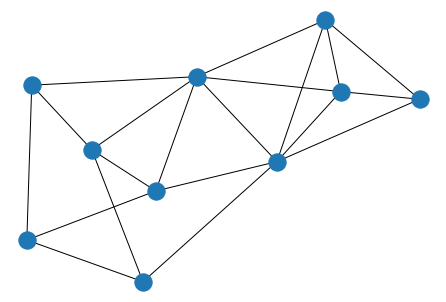

In [14]:


g = nx.triangular_lattice_graph(4,4)

# TODO: given degree, and CC generate ranwom graphs:

def generate_degree_CC_graphs(node_num, d, cc):
    # NOTE: use ws graph as bases:
    
    g = nx.watts_strogatz_graph(n=node_num, k=d, p=0.5)
    
    # get a center node, connect the neighbors:
    # by adj matrix: get the maximum degree node v, idx = Nei(v), then Nei(idx) \in idx, else: Nei(idx) \ idx_complement.
    
    adj = nx.to_numpy_array(g)
    print(adj.shape)
    max_degree_id = -1
    degrees = np.sum(adj, axis=0)
    print(degrees)
    return g
    
    
g = generate_degree_CC_graphs(10, d=5, cc=0.5)
    
nx.draw_spring(g)
plt.show()


# generate CC historgram with same degree
# cc without degree correlation bias



In [15]:
import utils
importlib.reload(utils)

import networkx as nx
from functools import reduce

importlib.reload(models)

def plot_cc_degree_distribution(cc_degree_graphs, cc_degree_y, g_label='train'):
    
    # random add edges:
    # add E edges, repeat for 5 times.
    print(type(cc_degree_graphs[0].todense()))

    data_graphs = [(cc_degree_y[i],np.mean(np.sum(cc_degree_graphs[i].todense(), axis=1)), np.mean(node_tri_cycles_feature(adj=cc_degree_graphs[i])).item(), i) for i in range(len(cc_degree_graphs))]

    data_graphs_s_train = sorted(data_graphs, key=lambda x: x[0])

    ccs = [d[0] for d in data_graphs_s_train]
    degrees = [d[1]/10 for d in data_graphs_s_train]
    tri_cycles = [d[2]/4 for d in data_graphs_s_train]



    plt.figure()
    plt.title(g_label)
    plt.plot(ccs, label='labels')
    plt.plot(degrees, label='degree',  linestyle='--')
    plt.plot(tri_cycles, label='tri_cycles', linestyle='-.')
    plt.legend()
    plt.show()




In [ ]:
# mixed cycle graphs:

cc_train_adjs, cc_train_y, cc_test_adjs, cc_test_y = generate_cc_no_degree_corr_samples(cc_range_num=20)

plot_cc_degree_distribution(cc_train_adjs, cc_train_y)
plot_cc_degree_distribution(cc_test_adjs, cc_test_y)


<class 'numpy.matrix'>


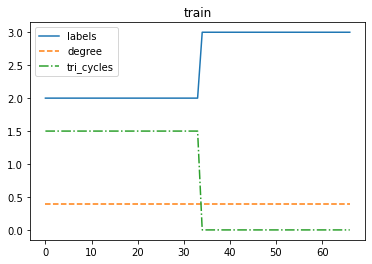

<class 'numpy.matrix'>


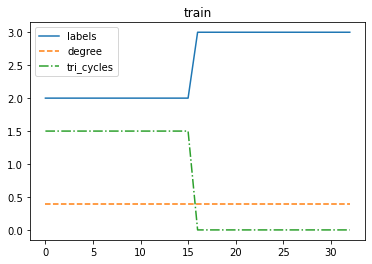

In [77]:
# Circulant graphs
S = list(np.arange(2, 10))
S = [2,3]
train_adjs, train_y, test_adjs, test_y = generate_circulant_graph_samples(each_class_num=50, N=41, S=S)
# TODO: predict long cycles.
plot_cc_degree_distribution(train_adjs, train_y)
plot_cc_degree_distribution(test_adjs, test_y)

# construct CC without degree-correlation biases

In [58]:
 # Shuffle, and then split.
# cc_train_adjs, cc_train_y, cc_test_adjs, cc_test_y


class NodeFeaRegister(object):
    def __init__(self, file_path=None):
        self.id = id(self)
        self.file_path = file_path
        if file_path is not None:
            self.funcs = {} # TODO: load from file.
            pass
        else:
            self.funcs = {
                "degree":node_degree_feature,
                "allone":node_allone_feature,
                "index_id":node_index_feature,
                "guassian":node_gaussian_feature,
                "tri_cycle":node_tri_cycles_feature,
                "kadj": node_k_adj_feature,
                "rand_id":node_random_id_feature
                }
        self.registered = []
        
    def register(self, func_name, **xargs):
        if func_name not in self.funcs:
            raise NotImplementedError
        self.registered.append((self.funcs[func_name], xargs))
    
    def get_registered(self):
        return self.registered
    
    def list_registered(self):
        for i, name, _ in enumerate(self.registered):
            print('index:', i, name)

def construct_node_features(alldata, fea_register:NodeFeaRegister):
    node_feature_list = []
    for fea_reg in fea_register.get_registered():
        node_feature_list.append(generate_node_feature(alldata, sparse=True, node_cons_func=fea_reg[0], **fea_reg[1]))
    return node_feature_list
    

In [ ]:
# NOTE: MixCycle graphs:

# NOTE: different init node features affect the performance to discover topology !!!!
# NOTE: try different random init node features or learnable node features.

node_fea_reg = NodeFeaRegister()
node_fea_reg.register('degree')
node_fea_reg.register('allone')
node_fea_reg.register('guassian')
node_fea_reg.register('tri_cycle')
node_fea_reg.register('kadj', k=2)

node_features = construct_node_features((cc_train_adjs, None, cc_test_adjs, None), node_fea_reg)


# NOTE: e.g., randomly choise from [1,2,3,4] or [1,2], or [1,2,3,4,...100], try different length.
ratios = [0.1, 0.3,0.6, 1.0]
rand_id_fea_trains = []
rand_id_fea_tests = []
node_fea_reg_ratio = NodeFeaRegister()
for ra in ratios:
    node_fea_reg_ratio.register('rand_id', ratio=ra)

rand_id_fea_list = construct_node_features((cc_train_adjs, None, cc_test_adjs, None), node_fea_reg_ratio)

cc_dataset = (cc_train_adjs, cc_train_y, cc_test_adjs, cc_test_y)

In [78]:
# NOTE: Circulant graphs:

node_fea_reg = NodeFeaRegister()
node_fea_reg.register('degree')
node_fea_reg.register('allone')
node_fea_reg.register('guassian')
node_fea_reg.register('tri_cycle')
node_fea_reg.register('index_id')
node_fea_reg.register('kadj', k=2)

node_features = construct_node_features((train_adjs, None, test_adjs, None), node_fea_reg)
cc_dataset = (train_adjs, train_y, test_adjs, test_y)

In [87]:

def train_cc_degree(cc_dataloader, feature_dim, lr=0.00001, gnn_name='gcn', epochs=300, opt='sgd'):
    import models
    import utils
    importlib.reload(utils)
    importlib.reload(models)

    args = utils.get_common_args()
    args = args.parse_args({})

    cc_gnn_evls_train = []
    cc_gnn_evls_test = []

    # TODO: fix the normali
    # ws_degree_graphwise_allone_dataloaders
    train_dataloader, test_dataloader = cc_dataloader
    train_evl, test_evl, cur_model = train_gnn(args, train_dataloader, test_dataloader, gnn_name=gnn_name,
                                    epoch=epochs,
                                    node_fea_dim=feature_dim,
                                    class_num=1,
                                    node_num=40, lr=lr, is_regression=True, is_node_wise=False, opt=opt)
    
    cc_gnn_evls_train.append(train_evl)
    cc_gnn_evls_test.append(test_evl)
        
    cc_gnn_evls_train[0].plot_metrics()
    cc_gnn_evls_test[0].plot_metrics()
    return cur_model


def plot_cc_degree_prediction(models_trained, cc_dataloader, adjs, adj_degree, g_label):
    
    data_graphs = [(adj_degree[i],np.mean(np.sum(adjs[i].todense(), axis=1)), np.mean(node_tri_cycles_feature(adj=adjs[i])).item(), i) for i in range(len(adjs))]

    data_graphs_s_train = sorted(data_graphs, key=lambda x: x[0])

    ccs = [d[0] for d in data_graphs_s_train]
    degrees = [d[1]/10 for d in data_graphs_s_train]
    tri_cycles = [d[2]/4 for d in data_graphs_s_train]


    cc_train_preds  = get_mid_feat(models_trained, cc_dataloader, prediction=True, logit=False)

    cc_train_preds = [cc_train_preds[i[-1]].item() for i in data_graphs_s_train]
    

    plt.figure()
    plt.plot(ccs, label='CC labels')
    plt.plot(cc_train_preds, label='CC predictions')
    plt.plot(degrees, label='Degrees')
    # plt.plot(tri_cycles, label='tri_cycles')
    plt.title(g_label)
    plt.legend()
    plt.show()

## TODO: test different ratios of random number node features. (08.29)
* ratios = [0.1, 0.3,0.6, 1.0]
* test correctness

In [ ]:
cc_dataloaders = []
for i in range(len(rand_id_fea_trains)):
    com_node_features_train = composite_node_features(allone_train_norm, rand_id_fea_trains[i], padding=False)
    com_node_features_test = composite_node_features(allone_test_norm, rand_id_fea_tests[i], padding=False)
    cc_dataloaders.append(assemble_dataloader(*construct_dataset(cc_dataset,
                            (com_node_features_train, com_node_features_test),
                             y_torch_type=torch.FloatTensor, sparse=True), cuda=False))


kadj_fea_train = composite_node_features(allone_train_norm, kadj_train, padding=True, padding_len=84)
kadj_fea_test = composite_node_features(allone_test_norm, kadj_test, padding=True, padding_len=84)
cc_dataloaders.append(assemble_dataloader(*construct_dataset(cc_dataset,
                        (kadj_fea_train, kadj_fea_test),
                            y_torch_type=torch.FloatTensor, sparse=True), cuda=False))

In [79]:
# NOTE: only all one and index features
# index_fea_train = composite_node_features(node_features[2][0], node_features[4][0], padding=False)
# index_fea_test = composite_node_features(node_features[2][1], node_features[4][1], padding=False)
cc_dataloaders = []

train_dataset, test_dataset, scalers, scalers_y = construct_dataset(cc_dataset, (node_features[4][0], node_features[4][1]), 
                       y_torch_type=torch.FloatTensor, sparse=True, K=2)

cc_dataloaders.append(assemble_dataloader(train_dataset, test_dataset , cuda=False))


feature len: 1


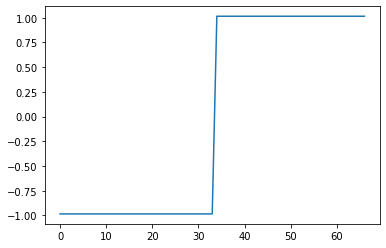

In [80]:
# TODO: check the normalization of labels and features:

x_check=[]
y_check=[]

for y in cc_dataloaders[0][0].dataset.y:
    y_check.append(y.item())
y_check= sorted(y_check)
plt.figure()
plt.plot(y_check)
plt.show()

xxfeature len: 1


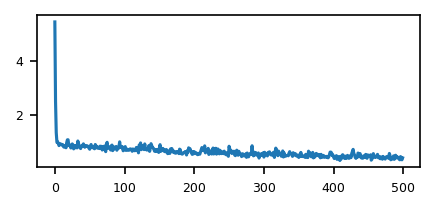

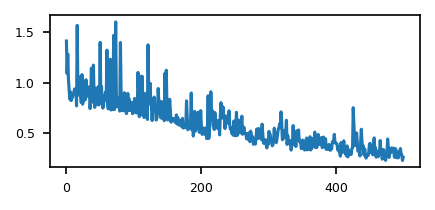

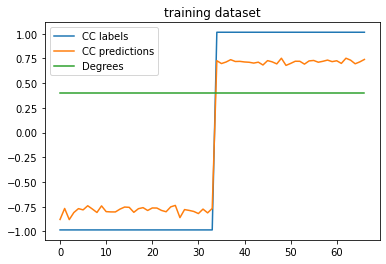

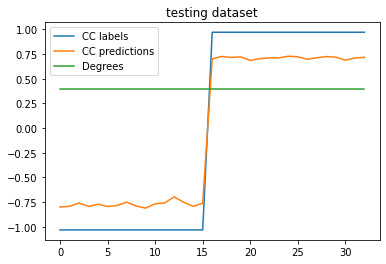

In [90]:
# NOTE: Circulant graphs, 09.04, only index features.
# NOTE: mean pool
train_y_norm = scalers_y[0].transform(train_y)
test_y_norm = scalers_y[1].transform(test_y)

for cc_dataloader in cc_dataloaders:
    fea_len = cc_dataloader[0].dataset.x[0].get_node_features().shape[-1]
    print('xxfeature len:', fea_len)
    models_trained = train_cc_degree(cc_dataloader, feature_dim=fea_len, lr=0.001,
                                     gnn_name='sparse_gin',epochs=500, opt='adam')
    plot_cc_degree_prediction(models_trained, cc_dataloader[0], train_adjs, train_y_norm, 'training dataset')
    plot_cc_degree_prediction(models_trained, cc_dataloader[1], test_adjs, test_y_norm, 'testing dataset')

In [ ]:
# NOTE: Circulant graphs, 09.04, try cycles features.
# NOTE: mean pool
# TODO: try onehot features and labels.

# NOTE: only all one and index features
tri_fea_train = composite_node_features(node_features[2][0], node_features[3][0], padding=False)
tri_fea_test = composite_node_features(node_features[2][1], node_features[3][1], padding=False)
cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset, (tri_fea_train, tri_fea_test), 
                       y_torch_type=torch.FloatTensor, sparse=True), cuda=False))


for cc_dataloader in cc_dataloaders:
    fea_len = cc_dataloader[0].dataset.x[0].get_node_features().shape[-1]
    print('xxfeature len:', fea_len)
    models_trained = train_cc_degree(cc_dataloader, feature_dim=fea_len, lr=0.0002, gnn_name='sparse_gin', epochs=500)
    plot_cc_degree_prediction(models_trained, cc_dataloader[0], train_adjs, train_y, 'training dataset')
    plot_cc_degree_prediction(models_trained, cc_dataloader[1], test_adjs, test_y, 'testing dataset')

# NOTE 1:  try $A^2 \odot {mask_i, i = 1..M}$ as input features, where $mask_i \in R^{1 \times N}$ is a learnable vector.

* mask the padded features, so N=128, set M=3.
* align mask features in the GNNAdapter module.
* Done, useless using mask.

# Try $A^2$ as the edge_index, 2022.09.02
* good performance

In [ ]:
# NOTE: only allone_train
cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (allone_train_norm, allone_test_norm), y_torch_type=torch.FloatTensor, sparse=True, K=2), 
    cuda=False))

In [ ]:
models_trained = train_cc_degree(cc_dataloaders[0], feature_dim=1, lr=0.001, gnn_name='sparse_gin', epochs=1000)

plot_cc_degree_prediction(models_trained, cc_dataloaders[0])

# convergence speed.

# Try A^3, K=3
* bad performance
* so only K=2 can count the cycles so that it further predict CC.

In [ ]:
# NOTE: only allone_train

cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (allone_train_norm, allone_test_norm), y_torch_type=torch.FloatTensor, sparse=True, K=3), 
    cuda=False))

models_trained = train_cc_degree(cc_dataloaders[0], feature_dim=1, lr=0.0012, gnn_name='sparse_gin', epochs=1000)

plot_cc_degree_prediction(models_trained, cc_dataloaders[0])

In [ ]:

# NOTE: Kadj as features:

pad_len = 128

com_node_features_train = composite_node_features(allone_train, kadj_train, padding=True, padding_len=pad_len)
com_node_features_test = composite_node_features(allone_test, kadj_test, padding=True, padding_len=pad_len)

cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (com_node_features_train, com_node_features_test), y_torch_type=torch.FloatTensor, sparse=True), cuda=False))

In [ ]:
# Train corr(degree, CC) = 0:
# NOTE: try mask features with k_adj. 2022.08.28, Sun.
# NOTE: try gcn/gin with k_adj_features. 
# NOTE: mean pool

models_trained = train_cc_degree(cc_dataloaders, feature_dim=128, lr=0.001, gnn_name='sparse_gin_mask',epochs=300)

plot_cc_degree_prediction(models_trained, cc_dataloaders)


# NOTE: small lr converges to local optimal, try only kadj later with a larger lr.


In [ ]:

# com_node_features_train = composite_node_features(allone_train, kadj_train[0], padding=False, padding_len=128)
# com_node_features_test = composite_node_features(allone_test, kadj_test[0], padding=False, padding_len=128)

com_node_features_train = composite_node_features(allone_train, tri_cycles_train[0], padding=False, padding_len=128)
com_node_features_test = composite_node_features(allone_test, tri_cycles_test[0], padding=False, padding_len=128)

cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (com_node_features_train, com_node_features_test), y_torch_type=torch.FloatTensor, sparse=True), cuda=False))


In [ ]:
# Train corr(degree, CC) = 0:
# NOTE: node_fea_dim = 128, add k_adj_features. 2022.08.23, failed
# NOTE: node_fea_dim = 2, add tri_cycles. 2022.08.26, running
# NOTE: try gcn/gin with k_adj_features.
# NOTE: mean pool

models_trained = train_cc_degree(cc_dataloaders, feature_dim=2, lr=0.00001, gnn_name='sparse_gin')

In [ ]:
# result of GCN:

# NOTE: node_fea_dim = 128, add k_adj_features. 2022.08.23
# NOTE: mean pool
# NOTE: node feature mean: 0.2
    
plot_cc_degree_prediction(models_trained, cc_dataloaders)


In [ ]:
# NOTE: kadj features without mask
com_node_features_train = composite_node_features(allone_train, kadj_train[0], padding=True, padding_len=128)
com_node_features_test = composite_node_features(allone_test, kadj_test[0], padding=True, padding_len=128)

cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (com_node_features_train, com_node_features_test), y_torch_type=torch.FloatTensor, sparse=True), cuda=False))



# allone_train[0]
print(cc_dataloaders[0][0].dataset.x[0].get_node_features().shape)

print(cc_dataloaders[0][0].dataset.x[0].get_node_features()[0, 75:88])

In [ ]:
# Train corr(degree, CC) = 0:
# NOTE: node_fea_dim = 128, add k_adj_features. 2022.08.27, run again
# NOTE: try gcn/gin with k_adj_features.
# NOTE: mean pool


models_trained = train_cc_degree(cc_dataloaders, feature_dim=128, lr=0.001, gnn_name='sparse_gin')

In [ ]:
# NOTE: node_fea_dim = 128, add k_adj_features. 2022.08.23
# NOTE: mean pool

# NOTE: node feature mean: 0.2
plot_cc_degree_prediction(models_trained, cc_dataloaders)

# NOTE: !!!!!!!! mask is useless !!!!!!!!!!!!!
# NOTE: !!!!!!!! cycles are useless too !!!!!!!!!!!!!

In [ ]:
# NOTE: only all one features

cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (allone_train, allone_test), y_torch_type=torch.FloatTensor, sparse=True), cuda=False))


In [ ]:
# NOTE: only all one features, try larger lr, 2022.08.28
models_trained = train_cc_degree(cc_dataloaders, feature_dim=1, lr=0.0005, gnn_name='sparse_gin', epochs=300)

In [ ]:
# NOTE: only all one features
plot_cc_degree_prediction(models_trained, cc_dataloaders)

In [ ]:
# NOTE: only all one and index features
index_fea_train,  index_fea_test =  generate_node_feature([(cc_train_adjs, None, cc_test_adjs, None)] ,node_index_feature,
                                                   sparse=True)

com_fea_train = composite_node_features(allone_train, index_fea_train[0], padding=False)
com_fea_test = composite_node_features(allone_test, index_fea_test[0], padding=False)

cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (com_fea_train, com_fea_test), y_torch_type=torch.FloatTensor, sparse=True), cuda=False))


In [ ]:

models_trained = train_cc_degree(cc_dataloaders, feature_dim=2, lr=0.001, gnn_name='sparse_gin', epochs=300)

# with 

# NOTE: only all one features and index features.
plot_cc_degree_prediction(models_trained, cc_dataloaders)

In [ ]:
# NOTE: only all one and degree features
degree_fea_train,  degree_fea_test =  generate_node_feature([(cc_train_adjs, None, cc_test_adjs, None)] ,node_degree_feature,
                                                   sparse=True)

com_fea_train = composite_node_features(allone_train, degree_fea_train[0], padding=False)
com_fea_test = composite_node_features(allone_test, degree_fea_test[0], padding=False)

cc_dataloaders = []
cc_dataloaders.append(assemble_dataloader(
    *construct_dataset(cc_dataset,
                        (com_fea_train, com_fea_test), y_torch_type=torch.FloatTensor, sparse=True), cuda=False))


In [ ]:

models_trained = train_cc_degree(cc_dataloaders, feature_dim=2, lr=0.001, gnn_name='sparse_gin', epochs=300)

# with 

# NOTE: only all one features and degree features
plot_cc_degree_prediction(models_trained, cc_dataloaders)

# TODO: Compare the CCA of the features of these models.

# check the correctness of dataset

In [ ]:
# TODO: check the density?



fig, axes = plt.subplots(3, 6, figsize=(8, 4), dpi=300)

train_dl, _ = dataloaders[5]
x_samples = train_dl.dataset.x
print(type(x_samples[0]))

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        index =  int(each_class_num) * j + i
        print('index of sample:', index)
        sns.heatmap(x_samples[index].A.cpu().numpy(), cbar=False, linecolor='indigo', square=True, linewidths=0.3,
                         cmap=ListedColormap(['white', 'purple']), ax=axes[i, j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.axis('off')
# ax.grid()
plt.show()


In [ ]:
# plot f1 curves:

def get_f1s(evls):
    mi_f1 = []
    ma_f1 = []
    w_f1 = []

    for evl in evls:
        mi_f1.append(evl.total_metrics['micro_f1'])
        ma_f1.append(evl.total_metrics['macro_f1'])
        w_f1.append(evl.total_metrics['weighted_f1'])
    return mi_f1, ma_f1, w_f1

    
    
def plot_f1_curves(mi_f1, ma_f1, w_f1):
    plt.figure(figsize=(4, 3), dpi=150)


    x = np.linspace(0, 1, 24)
    plt.plot(x, mi_f1,  marker="8")
    plt.plot(x, ma_f1,  marker=11)
    ax = plt.axes()
  
# Setting the background color of the plot 
# using set_facecolor() method
    ax.set_facecolor("snow")
    
    plt.grid()
    plt.show()

# plot performance of WS classification

In [ ]:
mi_f1, ma_f1, w_f1 = get_f1s(ws_gnn_evls)

print(mi_f1[0])
plot_f1_curves(mi_f1, ma_f1, w_f1)

In [ ]:
# combine wanted node features

# case: 1 only use index feas.

# case: 2, add allone vector can detect structural information:

train_combined_feature = composite_node_features(train_node_index_feas, train_node_allone_feas, train_node_std_feas)
test_combined_feature = composite_node_features(test_node_index_feas, test_node_allone_feas, test_node_std_feas)


In [ ]:

pos_en_dim = 10

dataloaders = []
for i, d in enumerate(data_sim):
    dataloaders.append(assemble_dataloader(
        *construct_dataset(d,
                           (train_combined_feature[i], test_combined_feature[i]), 
                                                              lap_encode=True,
                                                              lap_en_dim=pos_en_dim)))
    

In [ ]:
# NOTE: set the feature dimensions:

node_feature_dim = train_combined_feature.shape[-1]
graph_feature_dim = 1

print('node fea dim:', node_feature_dim)

In [ ]:
# try again TODO: plot the performance curve.

# 2. train by each method:

# MLP:

mlp_evls = []

for train_dataloader, test_dataloader in dataloaders:
    _, test_evl = train_mlp(train_dataloader, test_dataloader, epoch=100)
    mlp_evls.append(test_evl)


mi_f1, ma_f1, w_f1 = get_f1s(mlp_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

# train LSPE

In [ ]:
import utils
import importlib
importlib.reload(utils)



def train_lspe(train_loader, test_loader, node_fea_dim, epoch=1, plot=False, model_name='lspe', graph_fea_dim=1):
# use CNN to trian:
    args = base_args()
    lspe_model = choose_model(model_name, node_fea_dim=node_fea_dim, graph_fea_dim=graph_fea_dim)
    # opt = optim.Adam(mlp_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    opt = optim.SGD(lspe_model.parameters(), lr=0.0001)
    ce_loss_cal = CELossCal()

    trainer = utils.Trainer(lspe_model, optimizer=opt, loss_cal=ce_loss_cal)
    train_sim_evl= SimpleEvaluator(args)
    test_sim_evl= SimpleEvaluator(args)

    training(epoch, trainer, train_sim_evl, test_sim_evl,train_loader,test_loader)
    if plot:
        train_sim_evl.plot_metrics()
        test_sim_evl.plot_metrics()
        
    return train_sim_evl, test_sim_evl
    
# t_dl, v_dl = dataloaders[0]
# _, _ = train_lspe(t_dl, v_dl, epoch=100, plot=True)
# train_cnn(inva_train_dataloader, inva_test_dataloader, True)

# node feature dim=3, added std feature



# Train LSPE

In [ ]:
# NOTE: LSPE:
# NOTE: 6 classification

val_lspe_evls = []
train_lspe_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_lspe(train_dataloader, test_dataloader, node_fea_dim=node_feature_dim, model_name='lspe', epoch=100)
    val_lspe_evls.append(test_evl)
    train_lspe_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(val_lspe_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

In [ ]:
a = torch.ones(12).reshape(3, 4)
a.size(0)

# train CNN:

In [ ]:
cnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_cnn(train_dataloader, test_dataloader, epoch=100, graph_fea_dim=graph_feature_dim)
    cnn_evls.append((train_evl,test_evl))
    

In [ ]:
# node feature dim=3, added std feature

train_cnn_evls = [e[0] for e in cnn_evls]
test_cnn_evls = [e[1] for e in cnn_evls]

mi_f1, ma_f1, w_f1 = get_f1s(train_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


mi_f1, ma_f1, w_f1 = get_f1s(test_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

In [ ]:
# node feature dim=2

train_cnn_evls = [e[0] for e in cnn_evls]
test_cnn_evls = [e[1] for e in cnn_evls]

mi_f1, ma_f1, w_f1 = get_f1s(train_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


mi_f1, ma_f1, w_f1 = get_f1s(test_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

In [ ]:
# plot confusion:
# visualize the train loader:

# node feature dim=2


train_cnn_evls[4].plot_metrics()


train_dl, _ = dataloaders[4]


fig, axes = plt.subplots(3, 4, figsize=(8, 6), dpi=150)

x_samples = train_dl.dataset.x
print(x_samples[0][1].shape)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        index =  4*i+j
        print('index of sample:', index)
        sns.heatmap(x_samples[index][1].cpu().numpy(), cbar=False, linecolor='indigo', square=True, linewidths=0.3,
                         cmap=ListedColormap(['white', 'purple']), ax=axes[i, j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

plt.axis('off')
# ax.grid()
plt.show()



# train GIN with lspe:

In [ ]:
# use degree node features:
import utils
import importlib
importlib.reload(utils)

args = utils.get_common_args()

args = args.parse_args({})
args.pos_en = 'lap_pe'
args.pos_en_dim = pos_en_dim

gnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(args, train_dataloader, test_dataloader, gnn_name='gin', epoch=200, node_fea_dim=node_feature_dim)
    gnn_evls.append(test_evl)
    
# node feature dim=3, added std feature

In [ ]:

mi_f1, ma_f1, w_f1 = get_f1s(gnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)

# train GNN without laspe

In [ ]:
# use degree node features:

gnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader, gnn_name='gnn', epoch=200, node_fea_dim=node_feature_dim)
    gnn_evls.append(test_evl)
    

In [ ]:
# node feature dim=3, added std feature

mi_f1, ma_f1, w_f1 = get_f1s(gnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)



In [ ]:
# node feature dim=2

mi_f1, ma_f1, w_f1 = get_f1s(gnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)



In [ ]:
# plot confusion:
# plot loss function:

evl = gnn_evls[10]
evl.plot_metrics()



In [ ]:
# MLP gin:
# NOTE: 6 classification

gin_evls = []
train_gin_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader,
                                    node_fea_dim=node_feature_dim, gnn_name='gin', epoch=100)
    gin_evls.append(test_evl)
    train_gin_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

In [ ]:
# plot confusion:
# plot loss function:

evl = gin_evls[15]
evl.plot_metrics()



In [ ]:
# MLP gin:
# NOTE: 6 classification, 

# NOTE node feature dim=3, added std feature

gin_evls = []
train_gin_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader, 
                                    node_fea_dim=node_feature_dim, gnn_name='gin', epoch=100)
    gin_evls.append(test_evl)
    train_gin_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

# Di GIN
# NOTE:use both direction:
# NOTE: 6 classification, 3 features, direct
# NOTE: added lap_en:

In [ ]:
# use both direction:
# NOTE: 6 classification, 3 features, direct
# NOTE: added lap_en:
 

args = utils.get_common_args()

args = args.parse_args({})
args.pos_en = 'lap_pe'
args.pos_en_dim = pos_en_dim

gin_evls = []
train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(args, train_dataloader, test_dataloader,
                                    gnn_name='gin_direc', epoch=100, node_fea_dim=node_feature_dim)
    gin_evls.append(test_evl)
    train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


evl = gin_evls[1]
evl.plot_metrics()

evl = gin_evls[10]
evl.plot_metrics()

evl = gin_evls[15]
evl.plot_metrics()


In [ ]:
# use both direction:
# NOTE: 6 classification
gin_evls = []
train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader,gnn_name='gin_direc', epoch=100, node_fea_dim=node_feature_dim)
    gin_evls.append(test_evl)
    train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


evl = gin_evls[1]
evl.plot_metrics()

evl = gin_evls[10]
evl.plot_metrics()

evl = gin_evls[15]
evl.plot_metrics()


In [ ]:
# use both direction:
# NOTE: 6 classification
# NOTE: 3 node features !!

gin_evls = []
train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_gnn(train_dataloader, test_dataloader,gnn_name='gin_direc', epoch=100, node_fea_dim=node_feature_dim)
    gin_evls.append(test_evl)
    train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


evl = gin_evls[1]
evl.plot_metrics()

evl = gin_evls[10]
evl.plot_metrics()

evl = gin_evls[15]
evl.plot_metrics()


In [ ]:
# TODO: concate the allone features and index features, not together training.





In [ ]:
# try laplacian
# construct new features:


utils.calculate_normalized_laplacian()







In [ ]:
big_kernel_cnn_evls = []
for train_dataloader, test_dataloader in dataloaders:
    _, test_evl = train_cnn(train_dataloader, test_dataloader, epoch=200, cnn_name='cnn_big')
    big_kernel_cnn_evls.append(test_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(big_kernel_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)
    

In [ ]:
# NOTE: 6 class:

big_kernel_cnn_evls = []
cnn_train_evls = []
for train_dataloader, test_dataloader in dataloaders:
    train_evl, test_evl = train_cnn(train_dataloader, test_dataloader, epoch=200, cnn_name='cnn_big')
    big_kernel_cnn_evls.append(test_evl)
    cnn_train_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(big_kernel_cnn_evls)

plot_f1_curves(mi_f1, ma_f1, w_f1)


# Try Real-world dataset from PyG generic datasets
website: `https://pytorch-geometric.readthedocs.io/en/latest/notes/data_cheatsheet.html`

* graph classification:
    * TUDataset
    * ZINC

## TODO: 
1. use. # due: 6.30.
2. profile. # due: 7.1.

In [ ]:
# TODO: 1. how to use them.
# classTUDataset


import torch_geometric.datasets as pygdataset


tudataset = pygdataset.tu_dataset.TUDataset(root='/li_zhengdao/github/GenerativeGNN/dataset/', name='AIDS')





In [ ]:
a = tudataset.get(1)
a.y
print(type(a))

# TODO: transform to BaseGraph

In [ ]:
import models
import importlib
from models import BaseGraphUtils
importlib.reload(models)


refresh_import()

tu_base_graphs = []
for a in tudataset:
    tu_base_graphs.append(BaseGraphUtils.from_pyg_graph(a))

In [ ]:
tu_y = []
for g in tu_base_graphs:
    tu_y.append(g.label)
tu_y = torch.stack(tu_y, dim=0).squeeze()

train_tu_dataset = GraphDataset(x=tu_base_graphs, y=torch.LongTensor(tu_y))

In [ ]:
import utils
import importlib
import models
from models import GraphDataset

importlib.reload(utils)
importlib.reload(models)


train_x, train_y, test_x, test_y = utils.random_split_dataset(train_tu_dataset, [0.8, 0.2])

print(len(train_x))
from collections import Counter
tr_y = Counter(train_y.numpy())
print(tr_y)

tu_train_dataset = GraphDataset(x=train_x, y=train_y)
tu_test_dataset = GraphDataset(x=test_x, y=test_y)

tu_train_dataloader, tu_test_dataloader = assemble_dataloader(tu_train_dataset, tu_test_dataset)


In [ ]:
gg =train_tu_dataset.x[0]
print(gg.graph_type)

In [ ]:
# NOTE: torch.LongTensor(0) will always fail !!!!!!!!!!!!!!!!!
a = torch.from_numpy(np.array([0.0])).long()
d = torch.LongTensor(1).repeat(10).reshape(10, 1)
b = np.repeat(np.array([0]), 11)
c =torch.from_numpy(b).long().reshape(11, 1)

print(d.squeeze().shape)
print(c.squeeze().shape)
print(torch.cat([d, c], dim=0).shape)

In [ ]:
for x, y in tu_train_dataloader:
    print(x.batch_num)
    print(y.shape)
    print(x.adj_type)
    print(x.pyg_graph.num_nodes)
    break

In [ ]:
# profiling

# TUDataset.
# NOTE node feature dim=3, added std feature


args = utils.get_common_args()

args = args.parse_args({})
args.pos_en = 'lap_pe'
args.pos_en_dim = pos_en_dim


gin_evls = []
train_gin_evls = []
train_evl, test_evl = train_gnn(args, tu_train_dataloader, tu_test_dataloader, 
                                    node_fea_dim=node_feature_dim, gnn_name='lsd_gin', epoch=100)
gin_evls.append(test_evl)
train_gin_evls.append(train_evl)
    
mi_f1, ma_f1, w_f1 = get_f1s(gin_evls)

print(mi_f1[0])
print(ma_f1[0])
print(w_f1[0])
plot_f1_curves(mi_f1, ma_f1, w_f1)
    

In [ ]:

i = torch.tensor([[0,1,2,3,2], [0,1,2, 2,0]])
 
# 指定坐标上的值
v = torch.tensor([1,2,3,3, 1])
 
a = torch.sparse_coo_tensor(indices=i, values=v, size=[4, 4])
print(a)


# draw confusion map

In [ ]:

evl = big_kernel_cnn_evls[1]
evl.plot_metrics()

evl = big_kernel_cnn_evls[10]
evl.plot_metrics()



# try GCN + GNN. involve more spectral information.



# incorporate the spectral methods:




In [ ]:
# TODO: transform data, and construct node features.
# construct pipline for the data.
# like transform object in cv.


def trans_spectral(d_loader):
    
    


# TODO:
# in future, add node feature, distinguish topological feature
* add temporal information to node features.
* add non-tological related node features.

In [ ]:
# TODO:





# How to train a probabilistic model

# compare graph similarity in spectra domain

In [ ]:
from pygsp import graphs, filters
import numpy as np


G = graphs.Logo()
G.compute_fourier_basis()  # Fourier to plot the eigenvalues.
 # G.estimate_lmax() is otherwise sufficient.


In [ ]:
g = filters.Heat(G, tau=50)

DELTAS = [20, 30, 1090]
s = np.zeros(G.N)
s[DELTAS] = 1
s = g.filter(s)
print(s)
G.plot_signal(s, highlight=DELTAS)


In [ ]:
from numpy import linalg

# # construct G:

def normlized_laplacian(adj):
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    normalized_laplacian = np.eye(adj.shape[0]) - np.matmul(np.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)
    return normalized_laplacian

eigs = [linalg.eig(normlized_laplacian(adj)) for adj in samples]


fig, axes = plt.subplots(3, 4, figsize=(8, 6), dpi=100)
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i, j].plot(eigs[3*i+j][0].squeeze())


# d = np.array(adj.sum(1))
# d_inv_sqrt = np.power(d, -0.5).flatten()
# d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
# d_mat_inv_sqrt = sp.diags(d_inv_sqrt).toarray()
# normalized_laplacian = sp.eye(adj.shape[0]) - np.matmul(np.matmul(d_mat_inv_sqrt, adj), d_mat_inv_sqrt)
# return normalized_laplacian